[JSON-LD](https://json-ld.org/) is a flower blooming in the majestic ruins of the Semantic Web.

It's a way of describing an API of linked data, so that a computer can understand what its responses mean. But the description stays out of the way, so a human programmer can interact with the API the way they would any other. 

This post is going to be nerdier than usual. In this tutorial, we're going to look under the surface of the ConceptNet API, which is based on JSON-LD, and see how to use tools such as [pyld](https://github.com/digitalbazaar/pyld) to transform it into RDF and align it with other data.

Should you care? I think you should if the difference between "Linked Data" and plain old "data" is important to you. But this information isn't actually essential to use ConceptNet. It's a bonus that makes ConceptNet more interoperable with other things. This will not be on the test.

## Hanging ornaments on the JSON tree

To start with an example, here's the JSON-LD response that you get from the API query http://api.conceptnet.io/c/en/knowledge_graph.

Conveniently for the length of this example (and disappointingly in general), ConceptNet knows only one thing about the English term "knowledge graph", which is that in French it's "graphe de connaissances". So the "edges" value, which contains the meat of the response, is a list of one edge.

```json
{
  "@context": [
    "http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json"
  ],
  "@id": "/c/en/knowledge_graph",
  "edges": [
    {
      "@id": "/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]",
      "@type": "Edge",
      "dataset": "/d/wiktionary/fr",
      "end": {
        "@id": "/c/en/knowledge_graph",
        "@type": "Node",
        "label": "knowledge graph",
        "language": "en",
        "term": "/c/en/knowledge_graph"
      },
      "license": "cc:by-sa/4.0",
      "rel": {
        "@id": "/r/Synonym",
        "@type": "Relation",
        "label": "Synonym"
      },
      "sources": [
        {
          "@id": "/and/[/s/process/wikiparsec/1/,/s/resource/wiktionary/fr/]",
          "@type": "Source",
          "contributor": "/s/resource/wiktionary/fr",
          "process": "/s/process/wikiparsec/1"
        }
      ],
      "start": {
        "@id": "/c/fr/graphe_de_connaissances/n",
        "@type": "Node",
        "label": "graphe de connaissances",
        "language": "fr",
        "sense_label": "n",
        "term": "/c/fr/graphe_de_connaissances"
      },
      "surfaceText": null,
      "weight": 1.0
    }
  ]
}
```

Most of this reflects the way the ConceptNet 5 API has always looked. What tells you it's JSON-LD is a few properties that started showing up in version 5.5, with `@` signs in their names. In particular, there's a pointer to the `@context`, which is where you (or your software) would go to start understanding what the JSON-LD means. With JSON-LD, you can get more information than you would from the API response alone.

## Calling things by their true name

What's cool about JSON-LD is that it takes your API and makes it interoperable with RDF. And what's cool about RDF -- if you'll accept that there's anything cool about RDF -- is that it can assign everything a name, and that name is meaningful and globally unique.

Naming things is one of the traditional "hard problems of computer science", so this actually matters. And the way RDF names things should be immediately understandable to every developer: names are URLs.

Following the [fantasy trope](http://tvtropes.org/pmwiki/pmwiki.php/Main/IKnowYourTrueName), when you know the true name of something, you have power over it.

Having the URL for a term in RDF tells you whether it's the same as something you already know about. Computationally, you know more about what "JSON" is if you know it's the same as https://www.wikidata.org/wiki/Q2063 or http://dbpedia.org/resource/JSON.

And if you have the URL for something that you *don't* already know about, you can usually _go_ to that URL and find more information. For example, that's how you'd confirm that Wikidata's "Q2063" and DBPedia's "JSON" are the same thing as _each other_. That's what makes all of this information "Linked Data", not just data.

> **When you say "URL", you must actually mean "IRI".**
> 
> It's good to talk to you again, Imaginary Interlocutor, but do you have to be such a web-standards pedant? Nobody knows what an IRI is. I'm going to keep calling these URLs, especially because I really do intend every one of them that I produce to _locate_ a _resource_.

The names in ConceptNet may look like ad-hoc identifiers, like `"/c/en/knowledge_graph"` and `"cc:by-sa/4.0"`. The property names, such as `"dataset"`, look pretty ad-hoc too. But these are just short nicknames, and via JSON-LD, we can find the true names of all of these:

* http://api.conceptnet.io/c/en/knowledge_graph
* https://creativecommons.org/licenses/by-sa/4.0/
* http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#dataset

The way to turn the strings in the API response into these true names is using ConceptNet's [JSON-LD context](http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json). Don't get too bogged down in it right now. One thing it provides is prefixes that let us use shorter names for things. Here's the prefix that lets `"cc:by-sa/4.0"` point to the Creative Commons URL above:

    "cc": "http://creativecommons.org/licenses/",

It also has a base URL, for interpreting relative URLs such as `/c/en/knowledge_graph`. The base URL happens to be the URL of the context itself, because why not:

    "@base": "http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json",
    
Some of the property names are things that we define. This line says that "weight" is a property that's defined in ConceptNet's context (`cn:` for short), and its value is a floating-point number:

    "weight": {"@id": "cn:weight", "@type": "xsd:float"},

Some of the properties are already meaningfully defined elsewhere. For example, we can have "comment" fields in API responses. Its values are strings to be read by the API user. This notion of a comment already exists in RDF Schema.

    "comment": {"@id": "rdfs:comment", "@type": "xsd:string"},

With this line, we can specify that when we say "comment", we mean "rdfs:comment", which when you expand the prefix means "http://www.w3.org/2000/01/rdf-schema#comment".

> **Let's take a step back. What do you do with this kind of information?**
>
> I think the most likely user who cares about the linked data in ConceptNet is someone who's building something larger out of ConceptNet and other resources. This would match my experience in building ConceptNet, where the inputs that are available in RDF are the ones I can be confident that I'm handling correctly, even if they update in the future.
>
> Let's talk about how things used to be with WordNet. If I want to refer to a particular item in WordNet, such as the synset _{example, instance, illustration, representative}_, there are a number of ways I could describe it, and most of them probably wouldn't be consistent with anything else. I could give you synset names that you can look up, such as `example.n.01` or `illustration.n.03`. These numbers might change with new versions of WordNet, and there's no way to inherently know that they refer to the same thing.
>
> I could also give you an internal ID such as `05828980-n`, which at least is a single name for the synset, but _all_ of these IDs would change with new releases of WordNet.
>
> **And this really got better because of RDF?**
>
> Yep. When using multiple data sources that are based on WordNet, you used to need a table that tells you which IDs are the same as which other IDs -- basically a kind of Rosetta stone lining up names and numbers from different versions of WordNet. Hopefully some researcher somewhere has made the table you need.
> 
> But the fact that WordNet is in RDF now means that I know the global, true name that I can call this WordNet entry: http://wordnet-rdf.princeton.edu/id/05828980-n. I don't need a Rosetta stone to know what this URL refers to. I can even go to that URL to find out more about it.
>
> **But that's just the same internal ID shoved into a URL. How does that make a difference?**
>
> Putting it into a URL means that it's more than just an internal ID now. Regardless of where the ID number came from originally, it's an implicit promise that this URL consistently refers to the synset _{example, instance, illustration, representative}_.
>
> And, importantly, it suggests that if you're building something on top of WordNet, you should use the same URL to identify the same synset. These wordnet-rdf URLs are also used by the Open Multilingual WordNet project, so you can be sure of when terms in different languages are intended to refer to the same thing, and you can align the data OMW provides with WordNet data you get from other sources.


## Using PyLD

The PyLD library lets us interpret JSON-LD responses, and apply various standard transformations to them.

For example, maybe instead of our own API format, you want to see the data in ConceptNet in a format that some other project uses. One format you might like is N-Triples, a simple text format that's like CSV if CSV were annoying to parse. Each line is an RDF statement, containing the subject, the predicate, and the object, and ending with a dot. The URLs involved are fully expanded.

This format is also called N-Quads now. We could replace the dot with a fourth thing called a "named graph", but we don't.

To produce this format, we'll use `jsonld.normalize`. N-Quads is one of the two formats it can output.

In [1]:
from pyld import jsonld

In [2]:
def show_nquads(url):
    print(jsonld.normalize(url, {'format': 'application/nquads'}))

In [3]:
show_nquads('http://api.conceptnet.io/c/en/knowledge_graph')

<http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]> <http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#dataset> <http://api.conceptnet.io/d/wiktionary/fr> .
<http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]> <http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#end> <http://api.conceptnet.io/c/en/knowledge_graph> .
<http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]> <http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#license> <http://creativecommons.org/licenses/by-sa/4.0> .
<http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]> <http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#rel> <http://api.conceptnet.io/r/Synonym> .
<http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]> <http://api.conceptnet.io/ld/conceptnet5.6/context.ld.jso

There you go. It's not pretty, but everything is pretty much spelled out. With N-Quads format, you could process ConceptNet the same way as WordNet or DBPedia.

The other available format, besides N-Quads, is a list of dictionaries, which is a good format for working with this data programmatically when you're not writing it to a file, but is ridiculously verbose to look at:

In [4]:
edges = jsonld.normalize('http://api.conceptnet.io/c/en/knowledge_graph')['@default']
edges[:5]

[{'object': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/d/wiktionary/fr'},
  'predicate': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#dataset'},
  'subject': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]'}},
 {'object': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/c/en/knowledge_graph'},
  'predicate': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#end'},
  'subject': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/,/c/en/knowledge_graph/]'}},
 {'object': {'type': 'IRI',
   'value': 'http://creativecommons.org/licenses/by-sa/4.0'},
  'predicate': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json#license'},
  'subject': {'type': 'IRI',
   'value': 'http://api.conceptnet.io/a/[/r/Synonym/,/c/fr/graphe_de_connaissances/n/

## Example: displaying the graph

What we just got out of JSON-LD is a graph structure, and Python gives us ways to visualize graphs, such as the appropriately-named `graphviz` wrapper.

We can use this anonymous list-of-dictionaries format to provide input to graphviz. We just need some code that prettifies it a little bit.

In [5]:
import graphviz
from conceptnet5.uri import join_uri, split_uri
API_ROOT = 'http://api.conceptnet.io'

def short_name(value, max_length=40):
    """
    Convert an RDF value (given as a dictionary) to a reasonable label.
    """
    if value['type'] == 'blank node':
        return '_'
    elif value['type'] == 'IRI':    
        url = value['value']
        if '#' in url:
            # Show just the fragment of URLs with a fragment
            # (it's probably a property name)
            return url.split('#')[-1]

        # Give URLs relative to the root of our API
        if url.startswith(API_ROOT):
            short_url = url[len(API_ROOT):]
            # If the URL is too long, hide it
            if len(short_url) > max_length:
                pieces = split_uri(short_url)
                return join_uri(pieces[0], '...')
            else:
                return short_url
        else:
            return url.split('://')[-1]
    else:
        # Put literal values in quotes
        text = value['value'].replace(':', '')
        if len(text) > max_length:
            text = text[:max_length] + '...'
        return '"{}"'.format(text)

    
def show_graph(url, size=10):
    """
    Show the graph structure of a ConceptNet API response.
    """
    rdf = jsonld.normalize(url)['@default']
    graph = graphviz.Digraph(
        strict=False, graph_attr={'size': str(size), 'rankdir': 'LR'}
    )
    for edge in rdf:
        subj = short_name(edge['subject'])
        obj = short_name(edge['object'])
        pred = short_name(edge['predicate'])
        if subj and obj and pred:
            # Apply different styles to the nodes based on whether they're
            # literals, ConceptNet URLs, or other URLs
            if obj.startswith('"'):
                # Literal values
                graph.node(obj, penwidth='0')
            elif obj.startswith('/'):
                # ConceptNet nodes
                graph.node(obj, style='filled', fillcolor="#ddeeff")
            else:
                # Other URLs
                graph.node(obj, color="#558855")
            graph.edge(subj, obj, label=pred)
    
    return graph

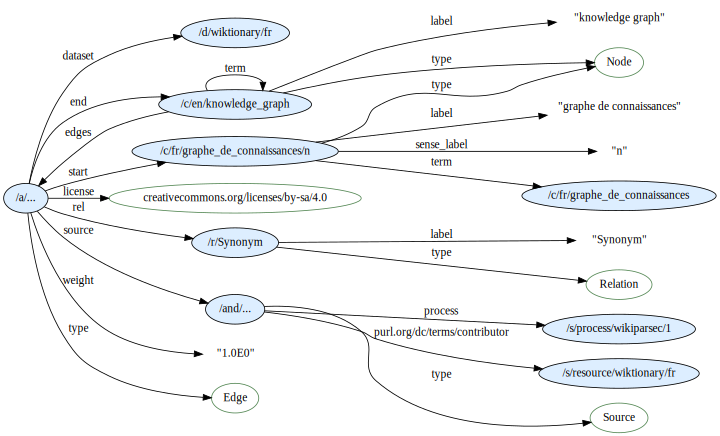

In [6]:
show_graph('http://api.conceptnet.io/c/en/knowledge_graph')

> **Wait. This tentacle monster is what a single assertion in ConceptNet looks like?**
>
> Yes. I bet you were expecting something more like this:

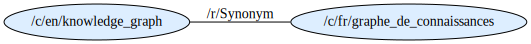

In [7]:
graph = graphviz.Graph(
    graph_attr={'size': '10', 'rankdir': 'LR'},
    node_attr={'style': 'filled', 'fillcolor': "#ddeeff"}
)
graph.edge('/c/en/knowledge_graph', '/c/fr/graphe_de_connaissances', label='/r/Synonym')
graph

> And you'll often see claims that RDF can describe knowledge graphs in this way, where each edge is a fact in the knowledge base.
>
> But this leaves no room for any interesting information about the edge, such as the sources that it comes from or how strongly we believe it. To talk _about_ an edge in RDF, you have to "reify" it -- to turn the edge into a node, and describe it with more edges. And that's what we've done.
>
> I'm not sure if anyone really wants to work with the un-reified facts in ConceptNet as RDF edges. I know that DBPedia has those, but often I see a DBPedia edge and find myself asking "okay, but really? Is this a real fact? Where did it come from?" Without reification, there's no answer.
>
> You've also got information about nodes, such as their label and their type, which are normal things to have in RDF.
>
> **Tentacles aside, could I put a lot of ConceptNet assertions into GraphViz and get a visualization of the structure of the ConceptNet graph?**
>
> You would get an illegible hairy mess that brings your image-rendering software grinding to a halt.
>
> Which is about the same as any other large graph visualization.

## Understanding the context in context

We have to go deeper.

Wait, no, we don't _have_ to do any of this. I _want_ to go deeper.

One goal I had for ConceptNet's JSON-LD context is that it should explain itself, much like [RDF Schema](https://www.w3.org/2000/01/rdf-schema#comment) did back in 2000. If you encounter the context file on its own, you should be able to read it and at least partially understand it. And hey, given that we've got all this JSON-LD stuff going on, it would be nice if a computer can also understand the stuff that you understand.

So that's what I did. The [context file](http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json) doesn't just describe an abstract vocabulary of properties; it also defines those properties. When the actual `"@context"` refers to identifiers such as `"cn:rel"`, the prefix `cn:` refers to a fragment in this file itself, so it's saying that `#rel` is defined somewhere in this file -- and here it is.

The definition tells you the types of things that each property relates, such as Nodes, Edges, or Sources. It relates them to other things in RDF when possible, such the fact that the `"rel"`, `"start"`, and `"end"` of a ConceptNet assertion play the roles of the  the `"rdf:predicate"`, `"rdf:subject"`, and `"rdf:object"` respectively. It provides additional explanations using the `"comment"` property. For example:

```json
{
  "@id": "#rel",
  "@type": "rdf:Property",
  "subPropertyOf": "rdf:predicate",
  "domain": ["#Edge", "#Feature"],
  "range": "#Relation",
  "comment": "Links to the kind of relationship that holds between two terms. In this API, the 'rel' will always be a ConceptNet URI beginning with /r/. In RDF, this would be called the 'predicate'."
}
```

These explanatory properties appear outside of the `"@context"` section, the only section that actually matters to how JSON-LD is processed. I wish I could have put comments _inside_ the `"@context"`, where the values really matter. But if I do that, it doesn't validate as proper JSON-LD. You need to have already parsed the `"@context"` to know what a comment is, and JSON-LD doesn't leave any wiggle room for circular definitions.

But outside of the `"@context"` section, I can put whatever I want. And what I choose to put there is these additional, explanatory properties that are also meaningful JSON-LD.

So you can interpret the context file, in the context of itself:

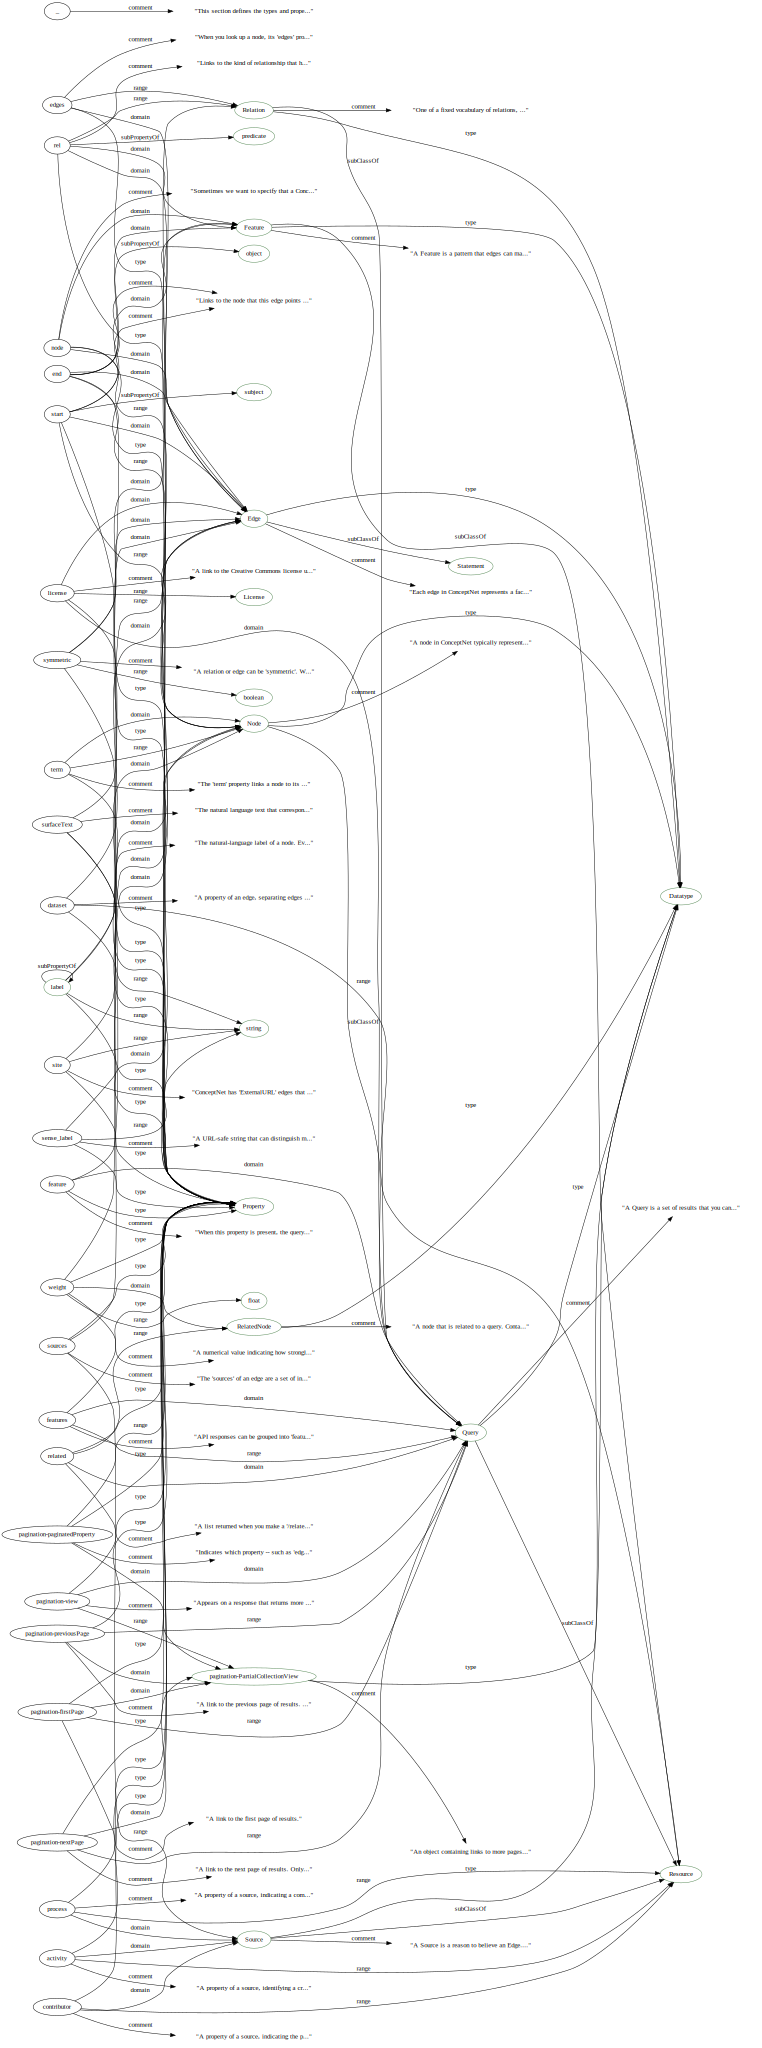

In [8]:
show_graph('http://api.conceptnet.io/ld/conceptnet5.6/context.ld.json', size=30)

Feel free to squint at this tangled web if you really like graphs about graphs. It's like API documentation, squared!

But speaking of that, remember that you can also read ConceptNet's API documentation [in English](https://github.com/commonsense/conceptnet5/wiki/API) instead of in JSON-LD.

> **Did... did you just make an ontology? That seems out of character.**
>
> The ontology was always there, Imaginary Interlocutor. We've just moved it from the realm of Platonic ideals, to a JSON file you can download.
>
> **In the end, what have you accomplished here?**
>
> The next time someone asks me if ConceptNet is available in RDF form, I can say "yes".